# **Keras và Weights & Biases**
> Tương tự như fastai, chúng ta sẽ cùng thử với một vài phương pháp train dữ liệu như:
> 1. Progressive Resize
> 2. LabelSmooth
> 3. MixUP

Chúng ta sẽ cùng sử dụng wandb để log lại metrics, lr, weights và các thông số khác.

In [ ]:
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing as PreprocessingLayers
from tensorflow.keras import backend as bk
import numpy as np
import math
import wandb
from wandb.keras import WandbCallback
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# Kiểm tra GPU:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Kiểm tra tensorflow & keras version:
tf.__version__, keras.__version__

('2.4.1', '2.4.0')

In [ ]:
# Tạo path dữ liệu:
path = '../data'
!ls {path}

test  train


# Giới hạn GPU

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
!nvidia-smi

Tue Sep 14 14:33:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.01    Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 39%   42C    P8    17W / 180W |    439MiB /  8192MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Tạo dữ liệu

In [ ]:
# Tạo dữ liệu
def create_raw_ds():
    bs = 32
    seed = 42
    train_ds = image_dataset_from_directory(
        f'{path}/train/'
        , labels='inferred'
        , label_mode='binary'
        , batch_size=bs
        , image_size=(460, 460)
        , seed=seed
        , validation_split=.2
        , subset='training'
    )

    valid_ds = image_dataset_from_directory(
        f'{path}/train/'
        , labels='inferred'
        , label_mode='binary'
        , batch_size=bs
        , image_size=(460, 460)
        , seed=seed
        , validation_split=.2
        , subset='validation'
    )
    return train_ds, valid_ds

In [ ]:
# Tạo preprocessing layer:
def create_preprocessed_ds(dataset, size):
    preprocessing_layer = keras.Sequential([
        PreprocessingLayers.RandomCrop(size, size, seed=42),
        PreprocessingLayers.RandomContrast([.5, 1.5]),
        PreprocessingLayers.RandomFlip(),
        keras.layers.Lambda(lambda x: keras.applications.resnet.preprocess_input(x))
    ])

    def preprocess_images(image, label):
        image = preprocessing_layer(image)
        return image, label
    
    dataset = dataset.map(preprocess_images)
    dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
def f1(y_true, y_pred):
    # Tính True Positive:
    TP = bk.sum(bk.round(bk.clip(y_true * y_pred, 0, 1)))
    
    # Tính Actual Positve: TP + FN
    TP_FN = bk.sum(bk.round(bk.clip(y_true, 0, 1)))
    
    # Tính Predicted Positve: TP + FP
    TP_FP = bk.sum(bk.round(bk.clip(y_pred, 0, 1)))
    
    return  (2 * TP)/(TP_FN + TP_FP + bk.epsilon())

In [ ]:
# Tạo hàm tạo model:
def create_model(size: int, num_classes: int=1):
    activation = 'sigmoid'
    if num_classes > 2: activation='softmax'
    resnet_model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(size, size, 3))
    for layer in resnet_model.layers:
        layer.trainable=False
    
    flatten = keras.layers.Flatten()(resnet_model.output)
    # Bổ sung dropout layer:
    dropout = keras.layers.Dropout(.5)(flatten)
    prediction = keras.layers.Dense(num_classes, activation=activation)(dropout)
    return keras.models.Model(inputs=resnet_model.input, outputs=prediction)

# Bắt đầu wandb

In [ ]:
# Khai báo tên user và project:
PROJECT_NAME = 'swift-swallow-classification'
USERNAME = 'ddpham'

In [ ]:
# # Tạo hàm khởi động run vs tên đơn giản:
# def init_neptune(run_name: str, user_name: str, project_name: str, run_id: str=None):
#     return neptune.init(project=f'{user_name}/{project_name}', name=run_name, run=run_id)

In [ ]:
# Sử dụng ! để chạy command line:
!wandb login

wandb: Currently logged in as: ddpham (use `wandb login --relogin` to force relogin)


In [ ]:
# Tạo tên của project và user của wandb
PROJECT_NAME = 'swift-swallow-classification'
ENTITY_NAME = 'ddpham'

# Progressive Resize
> Chúng ta sẽ thử với 3 size khác nhau: 128, 224 và 256. Với mỗi inputshape này, chúng ta sẽ phải tạo mới model, tuy nhiên, sẽ update weights của layer cuối cùng từ model cũ.

In [ ]:
?wandb.init

Signature:
wandb.init(
    job_type: Union[str, NoneType] = None,
    dir=None,
    config: Union[Dict, str, NoneType] = None,
    project: Union[str, NoneType] = None,
    entity: Union[str, NoneType] = None,
    reinit: bool = None,
    tags: Union[Sequence, NoneType] = None,
    group: Union[str, NoneType] = None,
    name: Union[str, NoneType] = None,
    notes: Union[str, NoneType] = None,
    magic: Union[dict, str, bool] = None,
    config_exclude_keys=None,
    config_include_keys=None,
    anonymous: Union[str, NoneType] = None,
    mode: Union[str, NoneType] = None,
    allow_val_change: Union[bool, NoneType] = None,
    resume: Union[bool, str, NoneType] = None,
    force: Union[bool, NoneType] = None,
    tensorboard=None,
    sync_tensorboard=None,
    monitor_gym=None,
    save_code=None,
    id=None,
    settings: Union[wandb.sdk.wandb_settings.Settings, Dict[str, Any], NoneType] = None,
) -> Union[wandb.sdk.wandb_run.Run, wandb.sdk.lib.disabled.RunDisabled, NoneType]
Do

## SIZE 128

In [ ]:
wandb.init(project=PROJECT_NAME, entity=ENTITY_NAME)

wandb: Currently logged in as: ddpham (use `wandb login --relogin` to force relogin)


In [ ]:
SIZE = 128

In [ ]:
train_ds, valid_ds = create_raw_ds()
train_ds = create_preprocessed_ds(train_ds, SIZE)
valid_ds = create_preprocessed_ds(valid_ds, SIZE)

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


### Tìm lr

In [ ]:
def record_lr(model, epoch, train_ds, valid_ds):
    lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * (10 ** (epoch/5)))
    optimizer = keras.optimizers.Adam(learning_rate=1e-8)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1])
    model.fit(train_ds, epochs=epoch, validation_data=valid_ds, callbacks=[lr_scheduler])

In [ ]:
bk.clear_session()
model = create_model(SIZE, 1)
record_lr(model, 40, train_ds, valid_ds)

Epoch 1/40
18/18 [==============================] - 71s 3s/step - loss: 1.9414 - accuracy: 0.4647 - f1: 0.4071 - val_loss: 1.1859 - val_accuracy: 0.5493 - val_f1: 0.4985
Epoch 2/40
18/18 [==============================] - 1s 68ms/step - loss: 1.9224 - accuracy: 0.5208 - f1: 0.4845 - val_loss: 1.1856 - val_accuracy: 0.5493 - val_f1: 0.4985
Epoch 3/40
18/18 [==============================] - 2s 89ms/step - loss: 2.0425 - accuracy: 0.4668 - f1: 0.4329 - val_loss: 1.1852 - val_accuracy: 0.5493 - val_f1: 0.4985
Epoch 4/40
18/18 [==============================] - 1s 69ms/step - loss: 2.0254 - accuracy: 0.4612 - f1: 0.3900 - val_loss: 1.1844 - val_accuracy: 0.5493 - val_f1: 0.4985
Epoch 5/40
18/18 [==============================] - 1s 67ms/step - loss: 1.9576 - accuracy: 0.4893 - f1: 0.4034 - val_loss: 1.1831 - val_accuracy: 0.5493 - val_f1: 0.4985
Epoch 6/40
18/18 [==============================] - 1s 63ms/step - loss: 1.9256 - accuracy: 0.5040 - f1: 0.4658 - val_loss: 1.1812 - val_accuracy:

In [ ]:
def plot_lr(history):
    plt.figure(figsize=(8,4))
    plt.semilogx(history["lr"], history["loss"])
    plt.axis([1e-8, 1e-1, 0, 2])
    plt.show()

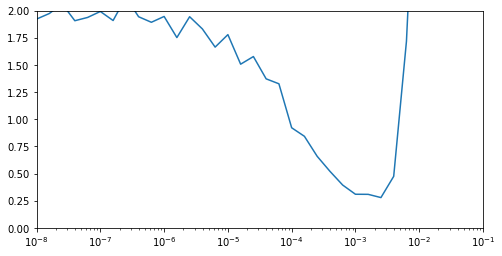

In [ ]:
plot_lr(model.history.history)

In [ ]:
def find_lr(history):
    lr_list = history['lr']
    loss_list = history['loss']
    empty_dict = {}
    for i in range(len(lr_list)):
        if (loss_list[i] <= 2) & (lr_list[i] <= 1e-1) & (i >= 1):
            empty_dict.update({lr_list[i]: loss_list[i-1] - loss_list[i]})
    max_gap = max(empty_dict.values())
    for key in empty_dict.keys():
        if empty_dict[key] == max_gap: print("max_lr =", key)
    return empty_dict

In [ ]:
lr_list = find_lr(model.history.history)
lr_list

max_lr = 1e-04


{1.5848931e-08: -0.05124068260192871,
 3.981072e-08: 0.15543925762176514,
 6.309573e-08: -0.030125737190246582,
 1e-07: -0.054941654205322266,
 1.5848931e-07: 0.08318948745727539,
 3.9810718e-07: 0.17916715145111084,
 6.3095735e-07: 0.05093514919281006,
 1e-06: -0.0534900426864624,
 1.5848932e-06: 0.19418013095855713,
 2.5118864e-06: -0.1917729377746582,
 3.9810716e-06: 0.11221802234649658,
 6.3095736e-06: 0.16725432872772217,
 1e-05: -0.11471498012542725,
 1.5848931e-05: 0.2717599868774414,
 2.5118865e-05: -0.07018733024597168,
 3.981072e-05: 0.20511078834533691,
 6.309574e-05: 0.04544806480407715,
 1e-04: 0.4044446349143982,
 0.00015848932: 0.078602135181427,
 0.00025118864: 0.18387120962142944,
 0.00039810716: 0.13788050413131714,
 0.00063095737: 0.12661796808242798,
 0.001: 0.0845695436000824,
 0.0015848932: 0.0008985996246337891,
 0.0025118864: 0.029725223779678345,
 0.0039810715: -0.19524118304252625,
 0.0063095735: -1.242298811674118}

### Bắt đầu lại

In [ ]:
def lr_cycle(epoch, max_lr):
    stepsize = 4
    epsilon = math.log(10, stepsize)
    remainder = epoch % (stepsize * 2)
    if (stepsize + 1) <= remainder: new_lr = max_lr * (epsilon ** (remainder - stepsize - 1))
    else: new_lr = max_lr / (epsilon ** (remainder - stepsize - 1))
    return new_lr

In [ ]:
max_lr = 1e-04
model = create_model(SIZE, 1)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_cycle(epoch, max_lr))
optimizer = keras.optimizers.Adam(learning_rate=max_lr/10)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1])
epochs = 24
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler, WandbCallback()])

Epoch 1/24
18/18 [==============================] - 5s 121ms/step - loss: 2.5312 - accuracy: 0.5838 - f1: 0.6215 - val_loss: 1.2498 - val_accuracy: 0.7183 - val_f1: 0.7655
Epoch 2/24
18/18 [==============================] - 1s 77ms/step - loss: 0.7688 - accuracy: 0.8703 - f1: 0.8753 - val_loss: 2.0456 - val_accuracy: 0.7042 - val_f1: 0.7861
Epoch 3/24
18/18 [==============================] - 1s 75ms/step - loss: 0.3193 - accuracy: 0.9177 - f1: 0.9267 - val_loss: 1.9003 - val_accuracy: 0.6972 - val_f1: 0.7863
Epoch 4/24
18/18 [==============================] - 1s 71ms/step - loss: 0.3087 - accuracy: 0.9130 - f1: 0.9204 - val_loss: 1.2962 - val_accuracy: 0.7042 - val_f1: 0.7890
Epoch 5/24
18/18 [==============================] - 1s 72ms/step - loss: 0.1792 - accuracy: 0.9275 - f1: 0.9286 - val_loss: 1.4308 - val_accuracy: 0.7183 - val_f1: 0.8031
Epoch 6/24
18/18 [==============================] - 1s 72ms/step - loss: 0.1411 - accuracy: 0.9541 - f1: 0.9588 - val_loss: 1.4069 - val_accurac

In [ ]:
# Lấy toàn bộ weights của layer cuối cùng (prediction)
last_layer_weights_128 = model.layers[-1].get_weights()
last_layer_weights_128

[array([[ 1.3188073e-02],
        [-1.4960763e-02],
        [-2.4788551e-02],
        ...,
        [ 2.2676813e-03],
        [-1.2200621e-02],
        [-9.5908377e-05]], dtype=float32),
 array([0.0034338], dtype=float32)]

## SIZE 224

In [ ]:
SIZE = 224

### Tạo lại dữ liệu

In [ ]:
train_ds, valid_ds = create_raw_ds()
train_ds = create_preprocessed_ds(train_ds, SIZE)
valid_ds = create_preprocessed_ds(valid_ds, SIZE)

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


### Cập nhật model
> Chúng ta cần cập nhật layer cuối cùng của model mới, dựa vào weights của model cũ.

In [ ]:
def update_model(model, weights):
    update_len = [len(weights[0]), len(weights[1])]
    last_weights = model.layers[-1].get_weights()
    
    # Cập nhật weights:
    for i in [0, 1]:
        np.put(last_weights[i], np.arange(update_len[i]),  weights[i])
    
    # bổ sung weights vào model:
    model.layers[-1].set_weights(last_weights)

### Tìm lr

In [ ]:
bk.clear_session()
# Tạo model mới:
model = create_model(SIZE, 1)

# Cập nhật weights cho layer cuối:
update_model(model, last_layer_weights_128)

# Tìm lr:
record_lr(model, 40, train_ds, valid_ds)

Epoch 1/40
18/18 [==============================] - 63s 2s/step - loss: 1.7478 - accuracy: 0.6989 - f1: 0.7262 - val_loss: 1.0619 - val_accuracy: 0.7254 - val_f1: 0.7562
Epoch 2/40
18/18 [==============================] - 2s 125ms/step - loss: 1.4674 - accuracy: 0.7308 - f1: 0.7619 - val_loss: 1.0619 - val_accuracy: 0.7254 - val_f1: 0.7562
Epoch 3/40
18/18 [==============================] - 2s 124ms/step - loss: 1.5430 - accuracy: 0.7084 - f1: 0.7471 - val_loss: 1.0619 - val_accuracy: 0.7254 - val_f1: 0.7562
Epoch 4/40
18/18 [==============================] - 2s 125ms/step - loss: 1.5740 - accuracy: 0.6887 - f1: 0.7187 - val_loss: 1.0618 - val_accuracy: 0.7254 - val_f1: 0.7562
Epoch 5/40
18/18 [==============================] - 2s 124ms/step - loss: 1.4006 - accuracy: 0.7080 - f1: 0.7466 - val_loss: 1.0617 - val_accuracy: 0.7254 - val_f1: 0.7562
Epoch 6/40
18/18 [==============================] - 2s 123ms/step - loss: 1.4537 - accuracy: 0.7312 - f1: 0.7593 - val_loss: 1.0615 - val_accu

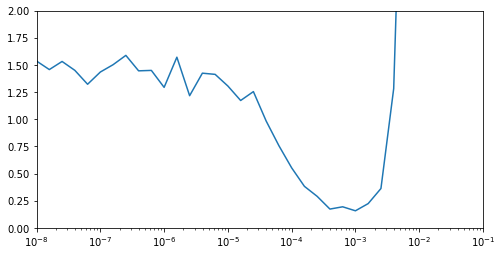

In [ ]:
plot_lr(model.history.history)

In [ ]:
lr_list = find_lr(model.history.history)
lr_list

max_lr = 2.5118864e-06


{1.5848931e-08: 0.07824468612670898,
 2.5118863e-08: -0.07449913024902344,
 3.981072e-08: 0.08165192604064941,
 6.309573e-08: 0.12790954113006592,
 1e-07: -0.11247527599334717,
 1.5848931e-07: -0.06753814220428467,
 2.5118865e-07: -0.08551132678985596,
 3.9810718e-07: 0.1421349048614502,
 6.3095735e-07: -0.003991484642028809,
 1e-06: 0.15600848197937012,
 1.5848932e-06: -0.27748537063598633,
 2.5118864e-06: 0.3541368246078491,
 3.9810716e-06: -0.20709705352783203,
 6.3095736e-06: 0.010843038558959961,
 1e-05: 0.10733306407928467,
 1.5848931e-05: 0.13307702541351318,
 2.5118865e-05: -0.0817645788192749,
 3.981072e-05: 0.27032268047332764,
 6.309574e-05: 0.22715187072753906,
 1e-04: 0.20387232303619385,
 0.00015848932: 0.1700226068496704,
 0.00025118864: 0.09206998348236084,
 0.00039810716: 0.1169959157705307,
 0.00063095737: -0.020969703793525696,
 0.001: 0.03680849075317383,
 0.0015848932: -0.06628480553627014,
 0.0025118864: -0.13869884610176086,
 0.0039810715: -0.9189730584621429}

### Bắt đầu lại

In [ ]:
max_lr = 2.5118864e-06
model = create_model(SIZE, 1)
update_model(model, last_layer_weights_128)

lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_cycle(epoch, max_lr))
optimizer = keras.optimizers.Adam(learning_rate=max_lr/10)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1])
epochs = 24
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler, WandbCallback()])

Epoch 1/24
18/18 [==============================] - 7s 206ms/step - loss: 1.7493 - accuracy: 0.6980 - f1: 0.7293 - val_loss: 1.1067 - val_accuracy: 0.7465 - val_f1: 0.7612
Epoch 2/24
18/18 [==============================] - 2s 121ms/step - loss: 1.4255 - accuracy: 0.7414 - f1: 0.7757 - val_loss: 1.0869 - val_accuracy: 0.7394 - val_f1: 0.7565
Epoch 3/24
18/18 [==============================] - 2s 121ms/step - loss: 1.2045 - accuracy: 0.7663 - f1: 0.7973 - val_loss: 1.0408 - val_accuracy: 0.7606 - val_f1: 0.7690
Epoch 4/24
18/18 [==============================] - 2s 124ms/step - loss: 1.1379 - accuracy: 0.7754 - f1: 0.8003 - val_loss: 1.0285 - val_accuracy: 0.7535 - val_f1: 0.7630
Epoch 5/24
18/18 [==============================] - 2s 127ms/step - loss: 1.1292 - accuracy: 0.7735 - f1: 0.7960 - val_loss: 1.0220 - val_accuracy: 0.7535 - val_f1: 0.7630
Epoch 6/24
18/18 [==============================] - 2s 122ms/step - loss: 1.1647 - accuracy: 0.7639 - f1: 0.7940 - val_loss: 1.0179 - val_ac

In [ ]:
last_layer_weights_224 = model.layers[len(model.layers)-1].get_weights()

## SIZE 256

In [ ]:
SIZE = 256

### Tạo lại dữ liệu

In [ ]:
train_ds, valid_ds = create_raw_ds()
train_ds = create_preprocessed_ds(train_ds, SIZE)
valid_ds = create_preprocessed_ds(valid_ds, SIZE)

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


### Tìm lr

In [ ]:
bk.clear_session()
# Tạo model mới:
model = create_model(SIZE, 1)

# Cập nhật weights cho layer cuối:
update_model(model, last_layer_weights_224)

# Tìm lr:
record_lr(model, 40, train_ds, valid_ds)

Epoch 1/40
18/18 [==============================] - 66s 3s/step - loss: 1.2942 - accuracy: 0.7359 - f1: 0.7614 - val_loss: 1.2118 - val_accuracy: 0.7113 - val_f1: 0.7412
Epoch 2/40
18/18 [==============================] - 3s 150ms/step - loss: 1.1101 - accuracy: 0.7820 - f1: 0.8023 - val_loss: 1.2118 - val_accuracy: 0.7113 - val_f1: 0.7412
Epoch 3/40
18/18 [==============================] - 3s 149ms/step - loss: 1.2133 - accuracy: 0.7716 - f1: 0.7947 - val_loss: 1.2117 - val_accuracy: 0.7113 - val_f1: 0.7412
Epoch 4/40
18/18 [==============================] - 3s 149ms/step - loss: 1.4527 - accuracy: 0.7512 - f1: 0.7728 - val_loss: 1.2114 - val_accuracy: 0.7113 - val_f1: 0.7412
Epoch 5/40
18/18 [==============================] - 3s 150ms/step - loss: 1.2324 - accuracy: 0.7461 - f1: 0.7747 - val_loss: 1.2113 - val_accuracy: 0.7113 - val_f1: 0.7412
Epoch 6/40
18/18 [==============================] - 3s 149ms/step - loss: 1.2169 - accuracy: 0.7324 - f1: 0.7580 - val_loss: 1.2108 - val_accu

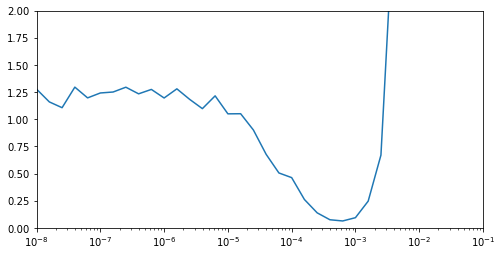

In [ ]:
plot_lr(model.history.history)

In [ ]:
find_lr(model.history.history)

max_lr = 3.981072e-05


{1.5848931e-08: 0.11729812622070312,
 2.5118863e-08: 0.05321300029754639,
 3.981072e-08: -0.18913650512695312,
 6.309573e-08: 0.09891331195831299,
 1e-07: -0.04521811008453369,
 1.5848931e-07: -0.008791208267211914,
 2.5118865e-07: -0.04423952102661133,
 3.9810718e-07: 0.06090712547302246,
 6.3095735e-07: -0.04048144817352295,
 1e-06: 0.07868015766143799,
 1.5848932e-06: -0.0840296745300293,
 2.5118864e-06: 0.09652423858642578,
 3.9810716e-06: 0.08557021617889404,
 6.3095736e-06: -0.11756229400634766,
 1e-05: 0.1653881072998047,
 1.5848931e-05: -0.0010486841201782227,
 2.5118865e-05: 0.14971864223480225,
 3.981072e-05: 0.22384333610534668,
 6.309574e-05: 0.171301007270813,
 1e-04: 0.04280129075050354,
 0.00015848932: 0.20122802257537842,
 0.00025118864: 0.1227497011423111,
 0.00039810716: 0.0636301040649414,
 0.00063095737: 0.011079050600528717,
 0.001: -0.030124135315418243,
 0.0015848932: -0.15233854949474335,
 0.0025118864: -0.4233666956424713}

### Bắt đầu lại

In [ ]:
max_lr = 3.981072e-05
model = create_model(SIZE, 1)
update_model(model, last_layer_weights_224)

lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_cycle(epoch, max_lr))
optimizer = keras.optimizers.Adam(learning_rate=max_lr/10)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1])
epochs = 8
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler, WandbCallback()])

Epoch 1/8
18/18 [==============================] - 7s 231ms/step - loss: 1.5392 - accuracy: 0.7269 - f1: 0.7409 - val_loss: 1.5318 - val_accuracy: 0.7394 - val_f1: 0.7862
Epoch 2/8
18/18 [==============================] - 3s 146ms/step - loss: 0.4249 - accuracy: 0.9296 - f1: 0.9359 - val_loss: 1.3775 - val_accuracy: 0.8028 - val_f1: 0.8012
Epoch 3/8
18/18 [==============================] - 3s 150ms/step - loss: 0.1546 - accuracy: 0.9668 - f1: 0.9709 - val_loss: 1.9932 - val_accuracy: 0.7535 - val_f1: 0.8054
Epoch 4/8
18/18 [==============================] - 3s 147ms/step - loss: 0.1329 - accuracy: 0.9574 - f1: 0.9618 - val_loss: 1.3060 - val_accuracy: 0.8239 - val_f1: 0.8318
Epoch 5/8
18/18 [==============================] - 3s 146ms/step - loss: 0.0145 - accuracy: 0.9949 - f1: 0.9958 - val_loss: 1.3746 - val_accuracy: 0.8028 - val_f1: 0.8203
Epoch 6/8
18/18 [==============================] - 3s 147ms/step - loss: 0.0052 - accuracy: 0.9972 - f1: 0.9976 - val_loss: 1.3994 - val_accuracy

Chúng ta có thể finish sau khi đã chạy xong.

In [ ]:
wandb.finish()

epoch,7
loss,0.01627
accuracy,0.99299
f1,0.99366
val_loss,1.47001
val_accuracy,0.80282
val_f1,0.83612
lr,0.00011
_runtime,2069
_timestamp,1631606913
_step,55


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██▁▂▂▃▃
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▄▄▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
accuracy,▁▅▆▇▇▇▇▇▇█████████▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇███
f1,▁▅▆▇▇▇▇▇▇█████████▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇███
val_loss,▃█▇▄▄▄▆▇▅▄▅▄▇▅▆▄▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▄█▄▄▅
val_accuracy,▃▂▂▃▄▃▂▁▃▃▂▂▁▅▃▅▄▃▄▆▅▅▅▆▆▆▆▆▇▇▇█████▅███
val_f1,▂▄▄▅▆▅▅▃▅▄▄▃▃▆▄▇▅▄▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▄▅▅▅▇▇█
lr,█▅▄▂▂▃█▅▃▂▂▃█▄▃▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▂
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃█████
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


# Label Smooth
> Label smooth là phương pháp sử dụng callbacks của keras.

In [ ]:
wandb.init(project=PROJECT_NAME, entity=ENTITY_NAME)

## Tạo lại dữ liệu

In [ ]:
SIZE = 224
train_ds, valid_ds = create_raw_ds()
train_ds = create_preprocessed_ds(train_ds, SIZE)
valid_ds = create_preprocessed_ds(valid_ds, SIZE)

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


## Tạo model

In [ ]:
model = create_model(SIZE, 1)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * (10 **(epoch/5)))
optimizer = keras.optimizers.Adam(learning_rate=1e-8)
loss = keras.losses.BinaryCrossentropy(label_smoothing=.1)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', f1])
epochs = 40
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler])

Epoch 1/40
18/18 [==============================] - 18s 579ms/step - loss: 1.8135 - accuracy: 0.4949 - f1: 0.5309 - val_loss: 1.2005 - val_accuracy: 0.5493 - val_f1: 0.5574
Epoch 2/40
18/18 [==============================] - 2s 123ms/step - loss: 1.8338 - accuracy: 0.4951 - f1: 0.5303 - val_loss: 1.2002 - val_accuracy: 0.5493 - val_f1: 0.5574
Epoch 3/40
18/18 [==============================] - 2s 125ms/step - loss: 1.7556 - accuracy: 0.4752 - f1: 0.5182 - val_loss: 1.1996 - val_accuracy: 0.5493 - val_f1: 0.5574
Epoch 4/40
18/18 [==============================] - 2s 124ms/step - loss: 1.7836 - accuracy: 0.4810 - f1: 0.5237 - val_loss: 1.1989 - val_accuracy: 0.5493 - val_f1: 0.5574
Epoch 5/40
18/18 [==============================] - 2s 124ms/step - loss: 1.9056 - accuracy: 0.4856 - f1: 0.5027 - val_loss: 1.1976 - val_accuracy: 0.5493 - val_f1: 0.5574
Epoch 6/40
18/18 [==============================] - 2s 124ms/step - loss: 1.7610 - accuracy: 0.4788 - f1: 0.5055 - val_loss: 1.1954 - val_a

### Tìm lr

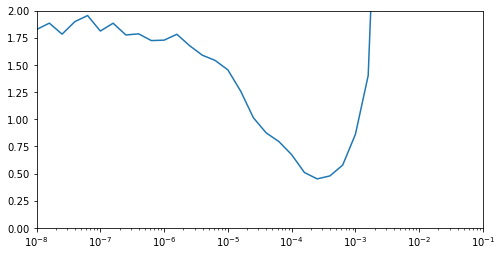

In [ ]:
plot_lr(model.history.history)

In [ ]:
find_lr(model.history.history)

max_lr = 2.5118865e-05


{1.5848931e-08: -0.05870985984802246,
 2.5118863e-08: 0.10106003284454346,
 3.981072e-08: -0.11495208740234375,
 6.309573e-08: -0.05610382556915283,
 1e-07: 0.14242148399353027,
 1.5848931e-07: -0.07188689708709717,
 2.5118865e-07: 0.10792052745819092,
 3.9810718e-07: -0.010087370872497559,
 6.3095735e-07: 0.06189250946044922,
 1e-06: -0.003990650177001953,
 1.5848932e-06: -0.054088592529296875,
 2.5118864e-06: 0.10524022579193115,
 3.9810716e-06: 0.08751511573791504,
 6.3095736e-06: 0.04775571823120117,
 1e-05: 0.08728897571563721,
 1.5848931e-05: 0.19481265544891357,
 2.5118865e-05: 0.24548804759979248,
 3.981072e-05: 0.138779878616333,
 6.309574e-05: 0.08014309406280518,
 1e-04: 0.12060868740081787,
 0.00015848932: 0.16393065452575684,
 0.00025118864: 0.05871939659118652,
 0.00039810716: -0.02751287817955017,
 0.00063095737: -0.09939923882484436,
 0.001: -0.2833666205406189,
 0.0015848932: -0.5399507880210876}

### Bắt đầu lại

In [ ]:
max_lr = 2.5118865e-05
model = create_model(SIZE, 1)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_cycle(epoch, max_lr))
optimizer = keras.optimizers.Adam(learning_rate=max_lr/10)
loss = keras.losses.BinaryCrossentropy(label_smoothing=.1)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', f1])
epochs = 80
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler, WandbCallback()])

Epoch 1/80
18/18 [==============================] - 6s 184ms/step - loss: 1.6835 - accuracy: 0.5940 - f1: 0.5928 - val_loss: 0.7707 - val_accuracy: 0.8239 - val_f1: 0.8584
Epoch 2/80
18/18 [==============================] - 2s 127ms/step - loss: 1.0541 - accuracy: 0.8686 - f1: 0.8899 - val_loss: 0.7683 - val_accuracy: 0.8662 - val_f1: 0.8778
Epoch 3/80
18/18 [==============================] - 2s 124ms/step - loss: 0.7903 - accuracy: 0.9066 - f1: 0.9134 - val_loss: 0.6995 - val_accuracy: 0.8732 - val_f1: 0.8842
Epoch 4/80
18/18 [==============================] - 2s 128ms/step - loss: 0.6999 - accuracy: 0.9380 - f1: 0.9422 - val_loss: 0.6408 - val_accuracy: 0.8732 - val_f1: 0.8868
Epoch 5/80
18/18 [==============================] - 2s 138ms/step - loss: 0.5378 - accuracy: 0.9757 - f1: 0.9796 - val_loss: 0.6357 - val_accuracy: 0.8803 - val_f1: 0.8983
Epoch 6/80
18/18 [==============================] - 2s 123ms/step - loss: 0.5720 - accuracy: 0.9618 - f1: 0.9649 - val_loss: 0.5994 - val_ac

label_smoothing hiện đang cho kết quả tốt nhất ở đây.

In [ ]:
wandb.finish()

epoch,79
loss,0.48181
accuracy,0.97723
f1,0.97898
val_loss,0.63976
val_accuracy,0.90141
val_f1,0.916
lr,7e-05
_runtime,960
_timestamp,1631610114
_step,79


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▂▂▁▁▂▁▁
accuracy,▁▆▇█▇▇██▇▇▇█▇▇███████▇██▇▇██▇▇██▇▇███▇██
f1,▁▇██▇▇██▇▇██▇▇███████▇██▇▇██▇▇███▇███▇██
val_loss,▄▃▂▁▁▅▂▁▁▃▁▁▃▅▂▂█▄▄▄▃▅▄▄▇▇▄▄▆▃▂▂▆▄▃▃▃▃▂▂
val_accuracy,▄▆▇█▆▃▅▆▅▄▆▇▅▃█▇▁▄▅▄▅▅▅▅▂▃▄▅▂▆▆▇▂▅▅▄▅▇▆█
val_f1,▄▆▆▇▆▄▆▇▆▅▆▆▅▄█▇▂▅▅▄▅▄▅▅▃▄▄▅▃▆▆▆▁▅▅▅▅▇▆▇
lr,█▃▁▁█▃▁▁█▃▁▁█▃▁▁█▃▁▁█▃▁▁█▃▁▁█▃▁▁█▃▁▁█▃▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


# MixUp
> Chúng ta sẽ thực hiện Mixup dựa trên ý tưởng và code từ đây : https://keras.io/examples/vision/mixup/
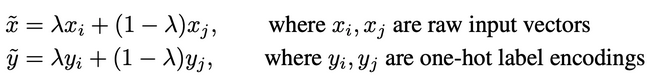
>
> Tuy nhiên, phần tạo ra lambda, chúng ta sẽ thực hiện đơn giản hơn dưới dạng input giá trị từ 0-1 mà thôi. Phần giá trị của lambda cần theo Beta distribution sẽ được thực hiện sau

## Tạo preprocessing layer
> Với phương pháp MixUp, chúng ta sẽ thực hiện MixUp trước, sau đó sẽ dùng CentralCrop, Rescale & Normalize.

In [ ]:
wandb.init(project=PROJECT_NAME, entity=ENTITY_NAME)

In [ ]:
# tạo dữ liệu
train_ds, valid_ds = create_raw_ds()

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


In [ ]:
# Tạo dữ liệu cho mixup
train_ds_dup = tf.data.Dataset.zip((train_ds, train_ds))

In [ ]:
# Tạo lại preprocess layer
def create_preprocessed_ds(dataset, size):
    preprocessing_layer = keras.Sequential([
        PreprocessingLayers.CenterCrop(size, size),
        keras.layers.Lambda(lambda x: keras.applications.resnet.preprocess_input(x))
    ])

    def preprocess_images(image, label):
        image = preprocessing_layer(image)
        return image, label
    
    return dataset.map(preprocess_images).cache().prefetch(tf.data.AUTOTUNE)

## Tạo Mixup
> idea của tạo MixUp là chúng ta sẽ duplicate dữ liệu tập train thành 2 training sets, với các ảnh đã được xóa trộn (shufffle), sau đó, chúng ta sẽ merge 2 tập lại với nhau theo tỷ lệ lambda. Và chúng ta sẽ được một tập train mới tương đồng về số lượng ảnh như tập ban đầu, nhưng ảnh đã được "mixed up" vs nhau.

In [ ]:
def mix_up(ds_one, ds_two, l: float=.2):
    # Tách dữ liệu ảnh và label của 2 batch:
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Tạo X, y:
    x_l = tf.reshape(tf.ones((batch_size, 1)) * l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(tf.ones((batch_size, 1)) * l, (batch_size, 1))

    # Thực hiện mixup giữa 2 batch, tỷ lệ 1:1
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

In [ ]:
# Tạo dữ liệu mix up:
train_ds_dup = train_ds_dup.map(lambda ds_one, ds_two: mix_up(ds_one, ds_two, l=.2), num_parallel_calls=tf.data.AUTOTUNE)
train_ds_dup

<ParallelMapDataset shapes: ((None, 460, 460, 3), (None, 1)), types: (tf.float32, tf.float32)>

/home/ddpham/miniconda3/envs/tf/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


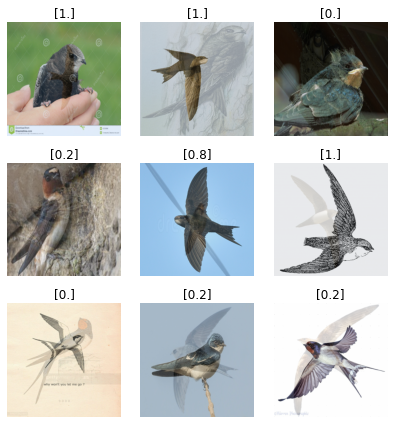

In [ ]:
plt.figure(figsize=(6,6))
for image in train_ds_dup.as_numpy_iterator():
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(image[0][i]/255.)
        plt.title(image[1][i])
        plt.axis("off")
        plt.tight_layout()
    break

In [ ]:
# Biến đổi dữ liệu cuối cùng
train_ds_dup = create_preprocessed_ds(train_ds_dup, 224)
valid_ds = create_preprocessed_ds(valid_ds, 224)

In [ ]:
train_ds_dup = train_ds_dup.cache().prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(tf.data.AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


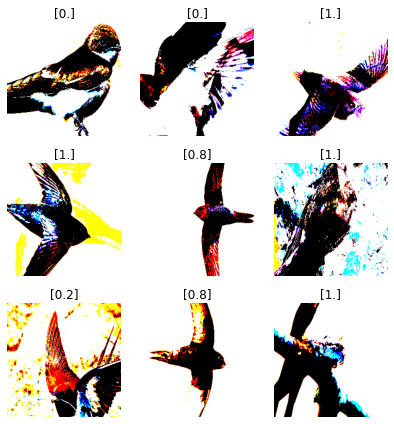

In [ ]:
# Kiểm tra lại dữ liệu:
plt.figure(figsize=(6,6))
for image in train_ds_dup.as_numpy_iterator():
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(image[0][i])
        plt.title(image[1][i])
        plt.axis("off")
        plt.tight_layout()
    break

## Tìm lr

In [ ]:
bk.clear_session()
model = create_model(224, 1)
record_lr(model, 40, train_ds_dup, valid_ds)

Epoch 1/40
18/18 [==============================] - 24s 738ms/step - loss: 1.9063 - accuracy: 0.2747 - f1: 0.4850 - val_loss: 1.6717 - val_accuracy: 0.4085 - val_f1: 0.3705
Epoch 2/40
18/18 [==============================] - 2s 130ms/step - loss: 1.7599 - accuracy: 0.2497 - f1: 0.4333 - val_loss: 1.6708 - val_accuracy: 0.4085 - val_f1: 0.3705
Epoch 3/40
18/18 [==============================] - 2s 131ms/step - loss: 1.8573 - accuracy: 0.2679 - f1: 0.4536 - val_loss: 1.6692 - val_accuracy: 0.4085 - val_f1: 0.3705
Epoch 4/40
18/18 [==============================] - 2s 124ms/step - loss: 1.8793 - accuracy: 0.2631 - f1: 0.4618 - val_loss: 1.6667 - val_accuracy: 0.4085 - val_f1: 0.3705
Epoch 5/40
18/18 [==============================] - 2s 125ms/step - loss: 1.9113 - accuracy: 0.2684 - f1: 0.4446 - val_loss: 1.6627 - val_accuracy: 0.4085 - val_f1: 0.3705
Epoch 6/40
18/18 [==============================] - 3s 150ms/step - loss: 1.7558 - accuracy: 0.2680 - f1: 0.4237 - val_loss: 1.6568 - val_a

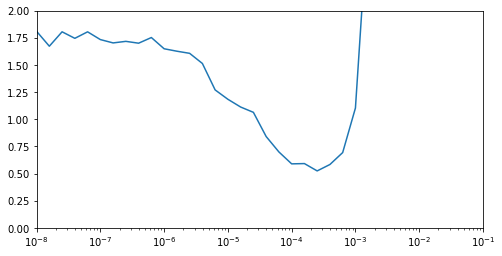

In [ ]:
plot_lr(model.history.history)

In [ ]:
find_lr(model.history.history)

max_lr = 6.3095736e-06


{1.5848931e-08: 0.13715600967407227,
 2.5118863e-08: -0.1323709487915039,
 3.981072e-08: 0.05991780757904053,
 6.309573e-08: -0.05971252918243408,
 1e-07: 0.0712728500366211,
 1.5848931e-07: 0.030665874481201172,
 2.5118865e-07: -0.014341592788696289,
 3.9810718e-07: 0.016941070556640625,
 6.3095735e-07: -0.052091240882873535,
 1e-06: 0.10325944423675537,
 1.5848932e-06: 0.022492408752441406,
 2.5118864e-06: 0.019550204277038574,
 3.9810716e-06: 0.09325742721557617,
 6.3095736e-06: 0.24327993392944336,
 1e-05: 0.08611094951629639,
 1.5848931e-05: 0.07125222682952881,
 2.5118865e-05: 0.04884755611419678,
 3.981072e-05: 0.2224225401878357,
 6.309574e-05: 0.14191418886184692,
 1e-04: 0.10955184698104858,
 0.00015848932: -0.0025777816772460938,
 0.00025118864: 0.06742870807647705,
 0.00039810716: -0.05904155969619751,
 0.00063095737: -0.10962152481079102,
 0.001: -0.40962183475494385}

## Bắt đầu lại

In [ ]:
max_lr = 6.3095736e-06
model = create_model(224, 1)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_cycle(epoch, max_lr))
optimizer = keras.optimizers.Adam(learning_rate=max_lr/10)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1])
epochs = 43
model.fit(train_ds_dup, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler, WandbCallback()])

Epoch 1/43
18/18 [==============================] - 7s 197ms/step - loss: 1.4637 - accuracy: 0.3598 - f1: 0.6270 - val_loss: 0.8378 - val_accuracy: 0.7183 - val_f1: 0.7807
Epoch 2/43
18/18 [==============================] - 2s 123ms/step - loss: 0.8084 - accuracy: 0.4689 - f1: 0.7957 - val_loss: 0.6425 - val_accuracy: 0.7535 - val_f1: 0.7711
Epoch 3/43
18/18 [==============================] - 2s 121ms/step - loss: 0.6689 - accuracy: 0.5051 - f1: 0.8008 - val_loss: 0.6345 - val_accuracy: 0.7606 - val_f1: 0.7941
Epoch 4/43
18/18 [==============================] - 2s 124ms/step - loss: 0.6133 - accuracy: 0.5223 - f1: 0.8424 - val_loss: 0.6355 - val_accuracy: 0.7606 - val_f1: 0.7951
Epoch 5/43
18/18 [==============================] - 2s 122ms/step - loss: 0.6423 - accuracy: 0.5234 - f1: 0.8670 - val_loss: 0.6119 - val_accuracy: 0.7817 - val_f1: 0.8071
Epoch 6/43
18/18 [==============================] - 2s 124ms/step - loss: 0.5832 - accuracy: 0.5272 - f1: 0.8663 - val_loss: 0.6083 - val_ac

Kết quả không thật sự tốt cho lắm nếu chúng ta nhìn vào số liệu của val

In [ ]:
wandb.finish()

epoch,42
loss,0.4341
accuracy,0.57443
f1,0.90692
val_loss,0.73434
val_accuracy,0.75352
val_f1,0.8082
lr,3e-05
_runtime,1673
_timestamp,1631613359
_step,42


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▄▃▃▃▃▃▂▂▂▁▂▂▂▂▁▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▆▆▆▆▆▆▆▇▇▇█▇██████████████████████████
f1,▁▄▅▆▆▆▆▆▇▇▇▇█▇▇▇▇▇███▇▇█▇██▇█████▇███▇█▇
val_loss,█▂▂▂▁▁▁▂▃▃▂▃▃▂▃▃▄▂▅▃▃▃▃▅█▂▃▄▄▄▃▇▅▆▄▅▄▆█▅
val_accuracy,▃▅▆▆▇▆▆▆▅▅▅▅▅▅▅▅▅▆▂▆▅▆▅▃▁█▆▆▅▅█▃▅▃▆▅▅▄▂▅
val_f1,▂▁▄▄▆▄▄▄▄▄▃▃▄▃▅▅▅▆▂▆▅▆▅▄▁▇▆▆▅▅█▄▅▄▆▅▅▅▃▆
lr,█▅▃▂▁▁▁▂█▅▃▂▁▁▂█▅▃▂▁▁▁▂█▅▃▁▁▁▂█▅▃▂▁▁▁▂█▃
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
